In [5]:
from random import uniform
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

MAPA_size = 100.0
MOTION_NOISE = 1.0
MEASUREMENT_NOISE = 2.0
N_LANDMARKS = 10
LANDMARKS = np.array(
    [[uniform(0, MAPA_size), uniform(0, MAPA_size)]
     for _ in range(N_LANDMARKS)])
     
display(MAPA_size)
display(MOTION_NOISE)
display(MEASUREMENT_NOISE)
display(LANDMARKS)

100.0

1.0

2.0

array([[20.30403098, 21.87436272],
       [43.05771462, 67.98381684],
       [19.50359214, 29.86244158],
       [ 7.72675934, 73.71595621],
       [81.47160299, 33.37611961],
       [16.84052557, 10.93946349],
       [39.78104931, 12.43969515],
       [97.00368096, 53.48019989],
       [65.39944618, 93.36209605],
       [32.59504396, 20.18739865]])

In [6]:
x0 = 50
y0 = 50

omega = np.array([[[0.0, 0.0] for _ in range(N_LANDMARKS + 1)]
                              for _ in range(N_LANDMARKS + 1)])

xi = np.array([[0.0, 0.0] for _ in range(N_LANDMARKS + 1)])
omega[0, 0, :] = np.array([1.0, 1.0])
xi[0, :] = np.array([x0, y0])

#display(omega)
display(xi)

array([[50., 50.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

# Robot class

In [7]:
class Robot:
    def __init__(self,
                 mapa_size=MAPA_size,
                 motion_noise=MOTION_NOISE,
                 measurement_noise=MEASUREMENT_NOISE):

        self.mapa_size = mapa_size
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.x = x0
        self.y = y0

    def move(self, dx, dy):
        x = self.x + dx + uniform(-1, 1)*self.motion_noise
        y = self.y + dy + uniform(-1, 1)*self.motion_noise

        self.x = x
        self.y = y

    def sense(self):
        Z = []
        for i, landmark in enumerate(LANDMARKS):
            dx = landmark[0] - self.x + uniform(-1, 1)*self.measurement_noise
            dy = landmark[1] - self.y + uniform(-1, 1)*self.measurement_noise
            Z.append([i, dx, dy])

        return Z

robot = Robot()
display(robot.sense())

[[0, -29.311723232427056, -27.25435076929012],
 [1, -4.998370755878222, 19.974428630341322],
 [2, -30.968884378523477, -19.63238064952238],
 [3, -42.72469146801188, 25.48897342581265],
 [4, 32.993126641595005, -16.22733016694305],
 [5, -33.144424230184384, -40.936569878448225],
 [6, -10.520152654219567, -38.307198337480244],
 [7, 48.260213433535654, 1.8143733281983767],
 [8, 15.538931108959025, 44.99718742766382],
 [9, -16.283067661131568, -31.378512146477256]]

# SLAM algorithm

In [8]:
def slam(i, dx, dy, Z):
    global omega, xi
    omega = np.insert(omega, i + 1, 0, axis=0)
    omega = np.insert(omega, i + 1, 0, axis=1)
    xi = np.insert(xi, i + 1, 0, axis=0)
    for mean in Z:
        j, x, y = mean
        omega[i, i] = omega[i, i] + 1/MEASUREMENT_NOISE
        omega[i, i + j + 2] = omega[i, i + j + 2] - 1/MEASUREMENT_NOISE
        omega[i + j + 2, i] = omega[i + j + 2, i] - 1/MEASUREMENT_NOISE
        omega[i + j + 2, i + j + 2] = omega[i + j + 2, i + j + 2] + 1/MEASUREMENT_NOISE
        xi[i, :] = xi[i, :] - np.array([x, y])/MEASUREMENT_NOISE
        xi[i + j + 2, :] = xi[i + j + 2, :] + np.array([x, y])/MEASUREMENT_NOISE
    omega[i, i] = omega[i, i] + 1/MOTION_NOISE
    omega[i + 1, i + 1] = omega[i + 1, i + 1] + 1/MOTION_NOISE
    omega[i + 1, i] = omega[i + 1, i] - 1/MOTION_NOISE
    omega[i, i + 1] = omega[i, i + 1] - 1/MOTION_NOISE
    xi[i, :] = xi[i, :] - np.array([dx, dy])/MOTION_NOISE
    xi[i + 1, :] = xi[i + 1, :] + np.array([dx, dy])/MOTION_NOISE
    mu_x = np.linalg.inv(omega[:, :, 0]).dot(xi[:, 0])
    mu_y = np.linalg.inv(omega[:, :, 1]).dot(xi[:, 1])
    return np.c_[mu_x, mu_y]

dx = [1 for _ in range(50)] + [0 for _ in range(50)] + [-1 for _ in range(50)] + [0 for _ in range(50)]
dy = [0 for _ in range(50)] + [1 for _ in range(50)] + [0 for _ in range(50)] + [-1 for _ in range(50)]

# Animation initialization

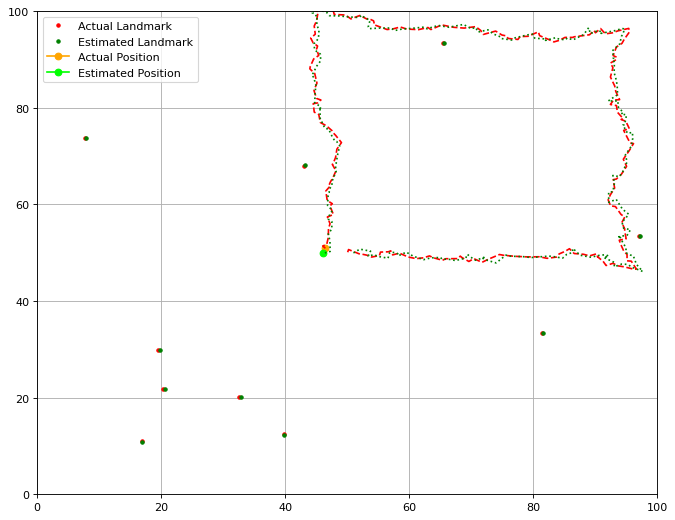

In [9]:
fig = plt.figure(figsize = (10,8) , dpi=80)
ax = plt.subplot()
ax.grid(True)
ax.plot(LANDMARKS[:, 0], LANDMARKS[:, 1], 'r.', label='Actual Landmark')
estimated_landmarks, = ax.plot([], [], 'g.', label='Estimated Landmark')
actual_position, = ax.plot([], [], color = 'orange', marker = 'o', label='Actual Position')
estimated_position, = ax.plot([], [], color='lime', marker='o', label='Estimated Position')
actual_path, = ax.plot([], [], 'r--')
estimated_path, = ax.plot([], [], 'g:')
actual_values = []
estimated_values = []

def init():
    ax.set_xlim(0, MAPA_size)
    ax.set_ylim(0, MAPA_size)
    plt.legend(loc='best')
    return (actual_position, estimated_position, estimated_landmarks,
            actual_path, estimated_path)

def animate(i):
    Z = robot.sense()
    mu = slam(i, dx[i], dy[i], Z)
    robot.move(dx[i], dy[i])
    actual_values.append([robot.x, robot.y])
    estimated_values.append([mu[i + 1, 0], mu[i + 1, 1]])
    actual_path.set_data([pos[0] for pos in actual_values], [pos[1] for pos in actual_values])
    estimated_path.set_data([pos[0] for pos in estimated_values], [pos[1] for pos in estimated_values])
    actual_position.set_data(robot.x, robot.y)
    estimated_position.set_data(mu[i + 1, 0], mu[i + 1, 1])
    est_lm = np.array([[mu[i + j + 2, 0], mu[i + j + 2, 1]] for j in range(N_LANDMARKS)])
    estimated_landmarks.set_data(est_lm[:, 0], est_lm[:, 1])
    return (actual_position, estimated_position, estimated_landmarks,
            actual_path, estimated_path)




anim = animation.FuncAnimation(fig, animate, 200, interval=50, init_func=init)
writergif = animation.PillowWriter(fps=30) 
anim.save('slam.gif', writer=writergif)